In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [7]:

from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

/project/6012927/jamalsm/SAM2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [8]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

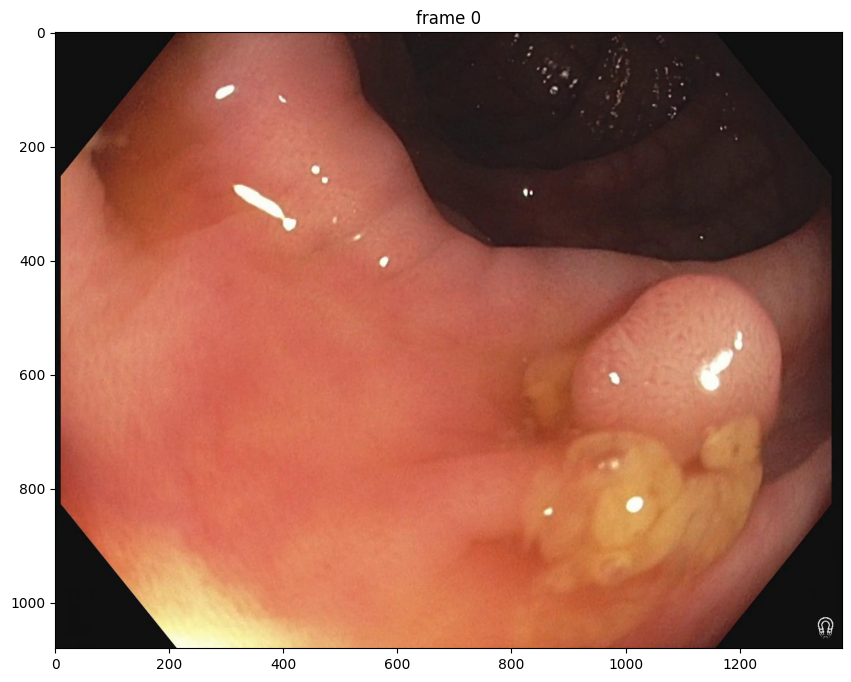

In [9]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./positive_cropped/seq2/images"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [10]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|█████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 18.34it/s]


In [11]:
predictor.reset_state(inference_state)

In [12]:
k = 0
msk_pth = "./positive_cropped/seq2/masks/" + frame_names[k]
mask_np = cv2.imread(msk_pth, cv2.IMREAD_GRAYSCALE)/255

seg_value = 1.
segmentation = np.where(mask_np == seg_value)

# Bounding Box
bboxes = 0, 0, 0, 0
if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))

    bboxes = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)

/project/6012927/jamalsm/SAM2/sam2/sam2_video_predictor.py:869: UserWarning: cannot import name '_C' from 'sam2' (/project/6012927/jamalsm/SAM2/sam2/__init__.py)

Skipping the post-processing step due to the error above. Consider building SAM 2 with CUDA extension to enable post-processing (see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


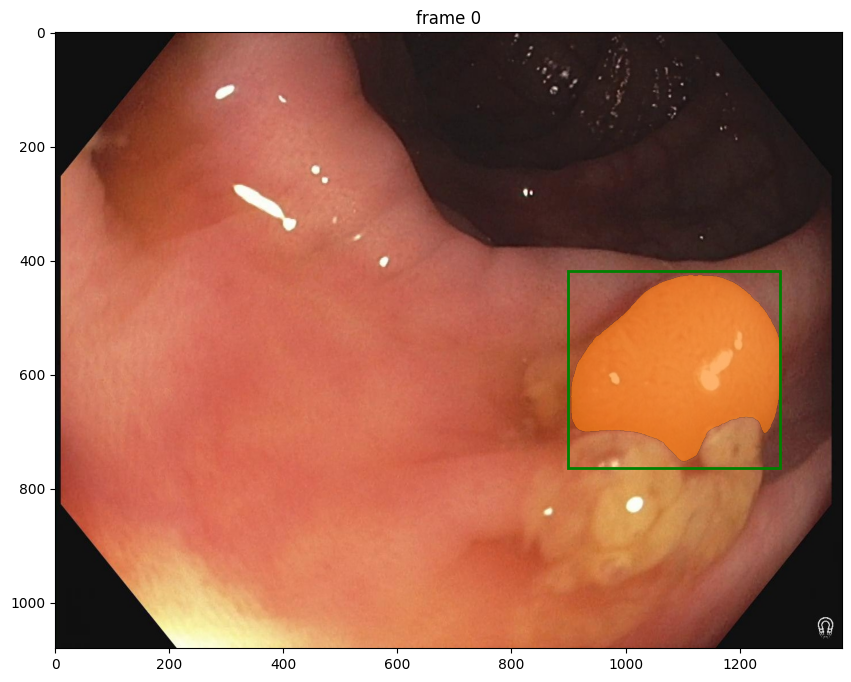

In [13]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = bboxes
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|███████████████████████████████████████████████████████████████| 63/63 [01:32<00:00,  1.46s/it]


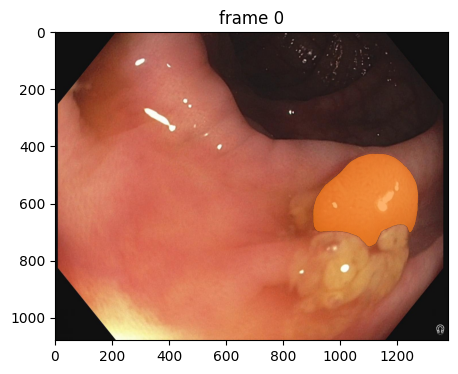

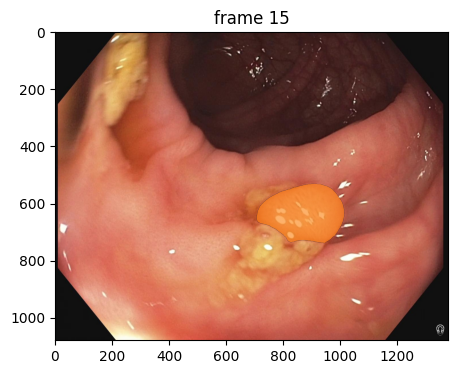

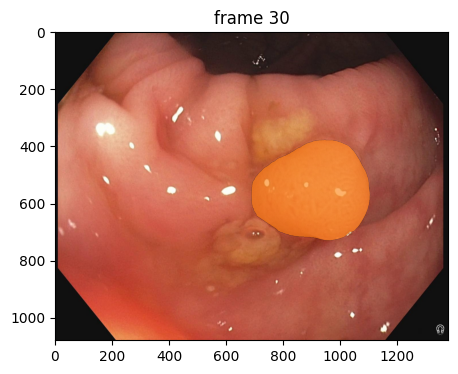

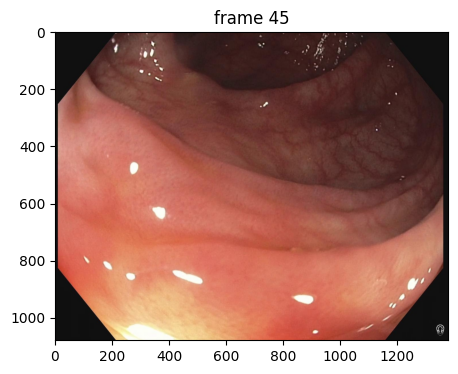

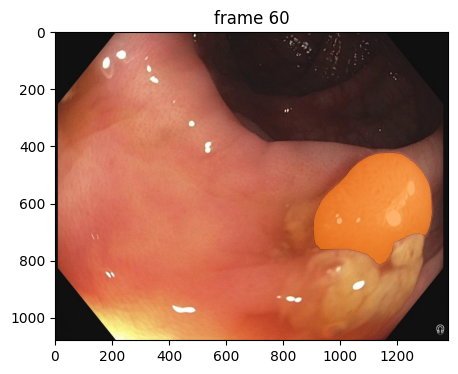

In [14]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [15]:
def intersectionAndUnion(imPred, imLab, numClass):

	# imPred = imPred * (imLab>0)

	# Compute area intersection:
	intersection = imPred * (imPred==imLab)
	(area_intersection,_) = np.histogram(intersection, bins=numClass, range=(1, numClass))

	# Compute area union:
	(area_pred,_) = np.histogram(imPred, bins=numClass, range=(1, numClass))
	(area_lab,_) = np.histogram(imLab, bins=numClass, range=(1, numClass))
	area_union = area_pred + area_lab - area_intersection
	area_sum = area_pred + area_lab
    
	return (area_intersection, area_union, area_sum)

In [16]:
import cv2
import glob

In [17]:
len(video_segments)

63

In [18]:
numClass = 1
arr = len(video_segments)
area_intersection = np.zeros((numClass, arr))
area_union = np.zeros((numClass, arr))
area_sum = np.zeros((numClass, arr))
for i in range(arr):
    msk_pth = "./positive_cropped/seq2/masks/" + frame_names[i]
    mask_np = cv2.imread(msk_pth, cv2.IMREAD_GRAYSCALE)/255
    (area_intersection[:,i], area_union[:,i], area_sum[:,i]) = intersectionAndUnion(video_segments[i][1][0], mask_np, numClass)
IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)

Dice = 1.0 * np.sum( 2 * area_intersection, axis=1) / np.sum( np.spacing(1) + area_sum, axis=1)

print(f"mIoU = {IoU} | mDice = {Dice}")

/tmp/ipykernel_219881/1508513407.py:7: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  (area_intersection,_) = np.histogram(intersection, bins=numClass, range=(1, numClass))
/tmp/ipykernel_219881/1508513407.py:10: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  (area_pred,_) = np.histogram(imPred, bins=numClass, range=(1, numClass))


mIoU = [0.78544421] | mDice = [0.87983058]
